In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks")
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 
def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5
def deprocess_img(x):
    return (x + 1.0) / 2.0

Mounted at /content/gdrive


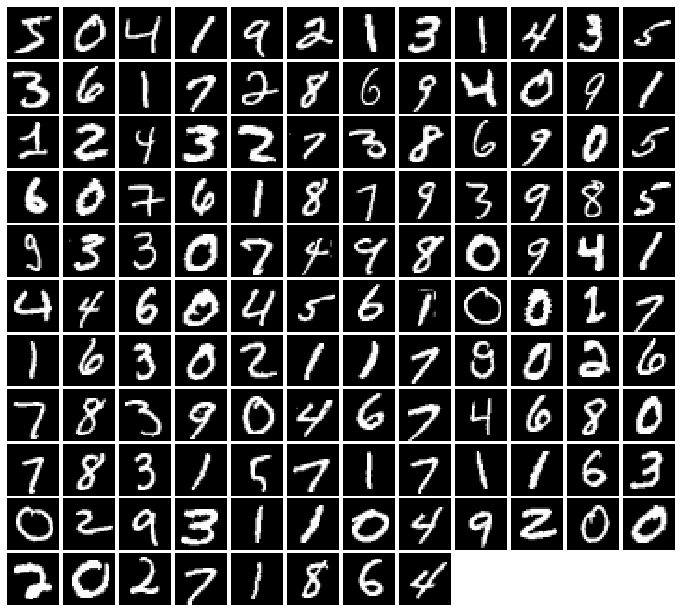

In [2]:
#数据处理
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))
imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)

In [3]:
#VAE结构如下，也是生成器
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x): #编码层
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() #e**(x/2)
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):#解码层
        h3 = F.relu(self.fc3(z))
        return F.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        return self.decode(z), mu, logvar # 解码，同时输出均值方差

In [4]:
#判别器
def discriminator():
    net = nn.Sequential(        
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    return net

In [5]:
#计算loss
def ls_discriminator_loss(scores_real, scores_fake): #判别器的loss
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake ** 2).mean()
    return loss
def ls_generator_loss(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    loss0 = 0.5 * ((recon_x - 1) ** 2).mean()
    # KL divergence
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return loss0+KLD

In [6]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

In [9]:
def train_a_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, num_epochs=30):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]   #128
            # 判别网络
            real_data = Variable(x).view(bs, -1).cuda() # 真实数据 [128,784]
            logits_real = D_net(real_data) # 判别网络得分
            fake_images,mu, logvar = G_net(real_data) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            fake_images,mu, logvar = G_net(real_data) # 生成的假的数据
            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake,real_data,mu,logvar) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
            

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iter: 0, D: 0.5801, G:114.1


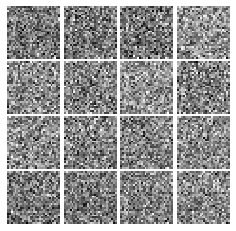


Iter: 250, D: 0.0742, G:0.5331


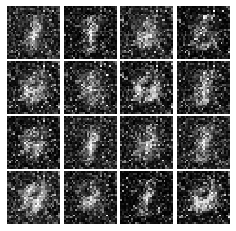


Iter: 500, D: 0.101, G:0.3126


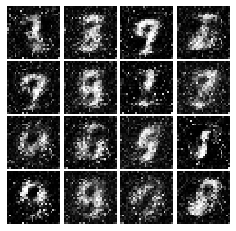


Iter: 750, D: 0.1407, G:0.2147


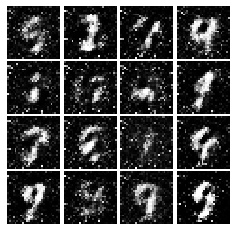


Iter: 1000, D: 0.1508, G:0.1627


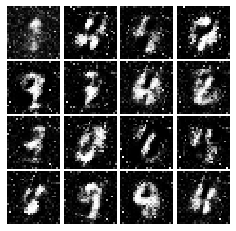


Iter: 1250, D: 0.1078, G:0.302


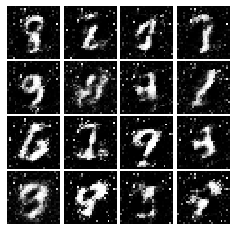


Iter: 1500, D: 0.1192, G:0.3751


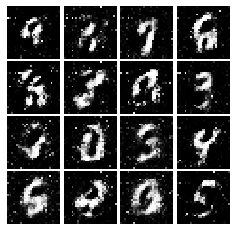


Iter: 1750, D: 0.1215, G:0.2678


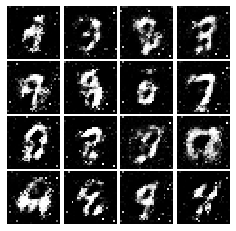


Iter: 2000, D: 0.1132, G:0.3695


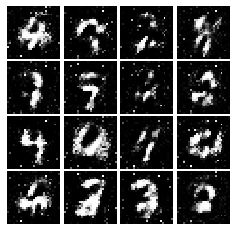


Iter: 2250, D: 0.1048, G:0.3098


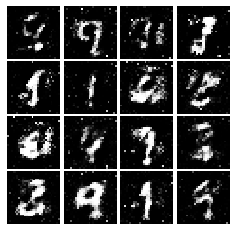


Iter: 2500, D: 0.08749, G:0.3167


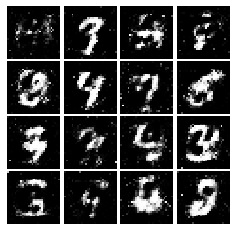


Iter: 2750, D: 0.09811, G:0.3659


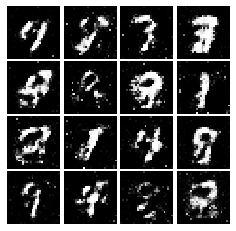


Iter: 3000, D: 0.1304, G:0.3593


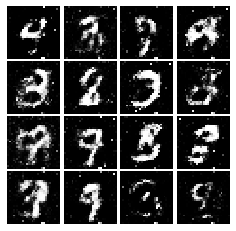


Iter: 3250, D: 0.08238, G:0.4032


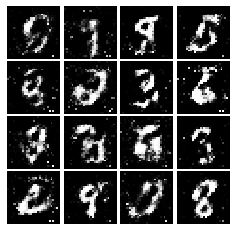


Iter: 3500, D: 0.08999, G:0.3944


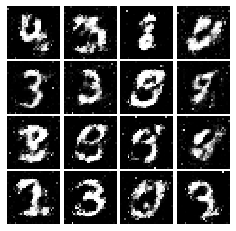


Iter: 3750, D: 0.1114, G:0.2514


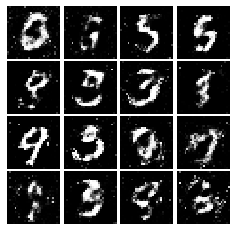


Iter: 4000, D: 0.09484, G:0.3811


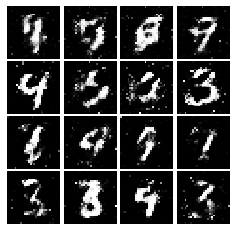


Iter: 4250, D: 0.09374, G:0.2752


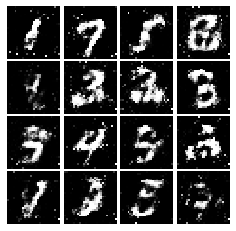


Iter: 4500, D: 0.1352, G:0.2671


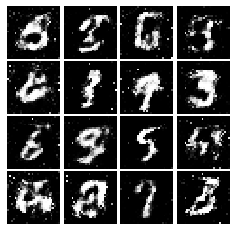


Iter: 4750, D: 0.1114, G:0.3933


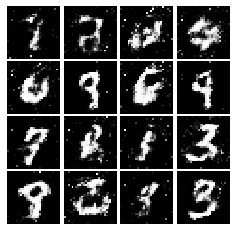


Iter: 5000, D: 0.1174, G:0.4605


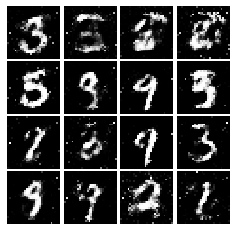


Iter: 5250, D: 0.1126, G:0.4868


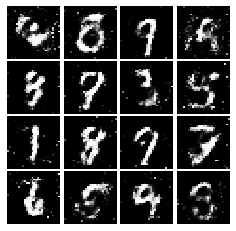


Iter: 5500, D: 0.1004, G:0.395


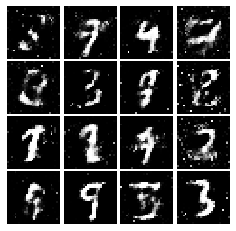


Iter: 5750, D: 0.08811, G:0.375


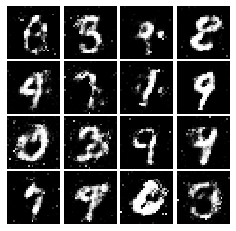


Iter: 6000, D: 0.1022, G:0.3471


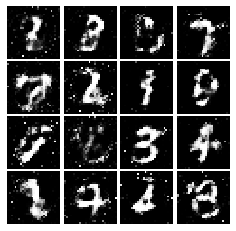


Iter: 6250, D: 0.09786, G:0.3261


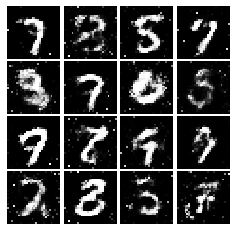


Iter: 6500, D: 0.115, G:0.2701


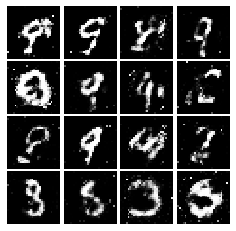


Iter: 6750, D: 0.08323, G:0.4126


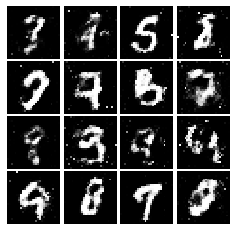


Iter: 7000, D: 0.08837, G:0.3551


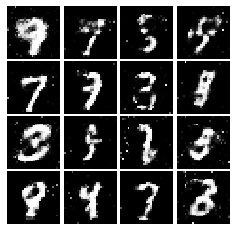


Iter: 7250, D: 0.08562, G:0.3535


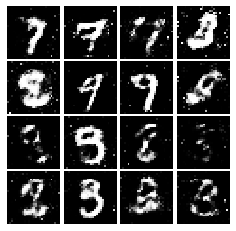


Iter: 7500, D: 0.1122, G:0.3459


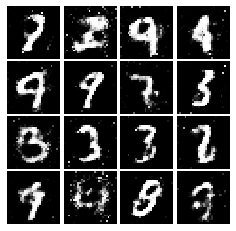


Iter: 7750, D: 0.09282, G:0.2554


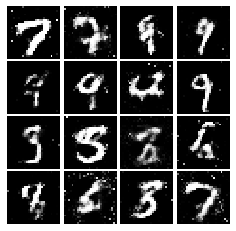


Iter: 8000, D: 0.1084, G:0.3546


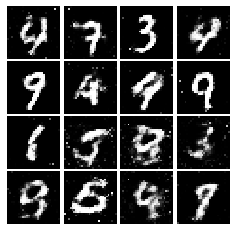


Iter: 8250, D: 0.09648, G:0.3391


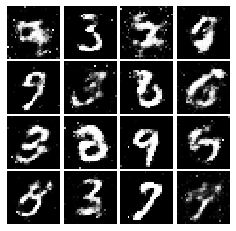


Iter: 8500, D: 0.09236, G:0.2954


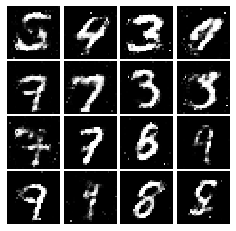


Iter: 8750, D: 0.1008, G:0.2926


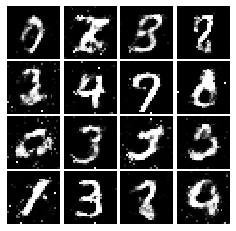


Iter: 9000, D: 0.08655, G:0.4287


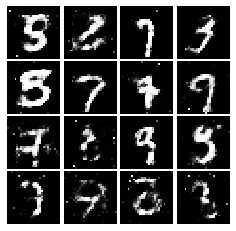


Iter: 9250, D: 0.07627, G:0.4232


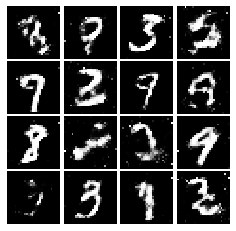


Iter: 9500, D: 0.1034, G:0.466


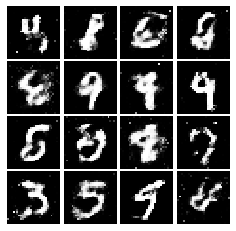


Iter: 9750, D: 0.09295, G:0.3243


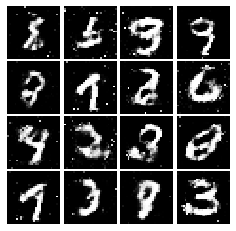


Iter: 10000, D: 0.0979, G:0.4361


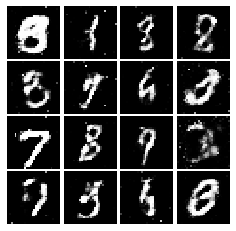


Iter: 10250, D: 0.1172, G:0.2968


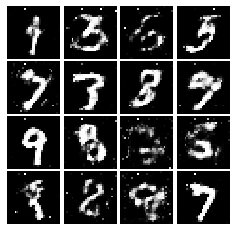


Iter: 10500, D: 0.1044, G:0.3162


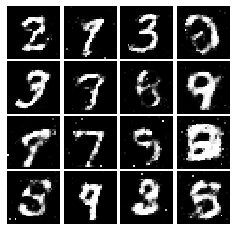


Iter: 10750, D: 0.1103, G:0.3336


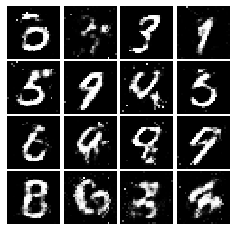


Iter: 11000, D: 0.1129, G:0.2991


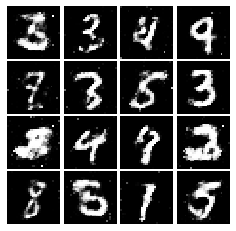


Iter: 11250, D: 0.08883, G:0.3454


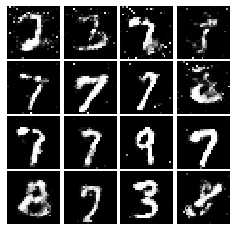


Iter: 11500, D: 0.0899, G:0.291


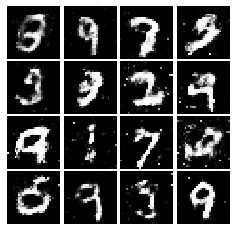

In [10]:
D = discriminator().cuda()
G = VAE().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, ls_discriminator_loss, ls_generator_loss)